In [51]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [52]:
from fastai.conv_learner import *
# from fastai.dataset import *
from fastai.models.resnet import vgg_resnet50

import json
from glob import glob

In [53]:
torch.backends.cudnn.benchmark=True

## Data

In [54]:
PATH = Path('../data/all')

In [55]:
def show_img(im, figsize=None, ax=None, alpha=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    return ax

In [56]:
VEHICLES=10
ROADS=7
ROAD_LINES=6

In [57]:
S_PREFIX = '13-cent'

In [58]:
from torchvision.datasets.folder import pil_loader
import torchvision.transforms as transforms
import torchvision.transforms.functional as TTF

### Create dataloader

In [59]:
class MatchedFilesDataset(Dataset):
    def __init__(self, fnames, y, tfms, path):
        self.path,self.fnames = path,fnames
        self.open_fn = pil_loader
        self.y=y
        self.open_y_fn = pil_loader
        assert(len(fnames)==len(y))
        
        self.n = self.get_n()
        self.c = self.get_c()
        self.tfms = tfms
#         self.sz = self.get_sz()
        
#     def get_sz(self): return self.transform.sz
    def get_x(self, i): return self.open_fn(os.path.join(self.path, self.fnames[i]))
    def get_y(self, i): return self.open_y_fn(os.path.join(self.path, self.y[i]))
    def get_n(self): return len(self.fnames)
    def get_c(self): return 2
    
    def get(self, tfms, x, y):
        for fn in tfms:
            #pdb.set_trace()
            x, y = fn(x, y)
        return (x, y)
    
    def __getitem__(self, idx):
        x,y = self.get_x(idx),self.get_y(idx)
        return self.get(self.tfms, x, y)
    
    def __len__(self): return self.n

    def resize_imgs(self, targ, new_path):
        dest = resize_imgs(self.fnames, targ, self.path, new_path)
        return self.__class__(self.fnames, self.y, self.transform, dest)

In [60]:

# Seems to speed up training by ~2%
class DataPrefetcher():
    def __init__(self, loader, stop_after=None):
        self.loader = loader
        self.dataset = loader.dataset
        self.stream = torch.cuda.Stream()
        self.stop_after = stop_after
        self.next_input = None
        self.next_target = None

    def __len__(self):
        return len(self.loader)
    
    def preload(self):
        try:
            self.next_input, self.next_target = next(self.loaditer)
        except StopIteration:
            self.next_input = None
            self.next_target = None
            return
        with torch.cuda.stream(self.stream):
            self.next_input = self.next_input.cuda(async=True)
            self.next_target = self.next_target.cuda(async=True)

    def __iter__(self):
        count = 0
        self.loaditer = iter(self.loader)
        self.preload()
        while self.next_input is not None:
            torch.cuda.current_stream().wait_stream(self.stream)
            input = self.next_input
            target = self.next_target
            self.preload()
            count += 1
            yield input, target
            if type(self.stop_after) is int and (count > self.stop_after):
                break

In [61]:
def crop_bg_pil(x,y):
    w, h = x.size
    top = int(h/3.75)
    bot = int(h*.9 + h/150)
    pad_right=32-w%32
    return TTF.crop(x, top, 0, bot-top, w+pad_right), TTF.crop(y, top, 0, bot-top, w+pad_right)

In [62]:
class RHF(object):
    def __init__(self, p=0.5): self.p = p
    def __call__(self, x, y):
        if random.random() < self.p:
            return TTF.hflip(x), TTF.hflip(y)
        return x,y

In [63]:
class RR(object):
    def __init__(self, degrees=2): self.degrees = degrees
    def __call__(self, x, y):
        angle = random.uniform(-self.degrees, self.degrees)
        return TTF.rotate(x, angle), TTF.rotate(y, angle)

In [64]:
def tfm_x_wrapper(tfm):
    return lambda x,y: (tfm(x), y)

In [65]:
class RC():
    def __init__(self, targ_sz):
        self.targ_sz = targ_sz

    def __call__(self, x, y):
        rand_w = random.uniform(0, 1)
        rand_h = random.uniform(0, 1)
        w,h = x.size
        t_w,t_h = self.targ_sz
        start_x = np.floor(rand_w*(w-t_w)).astype(int)
        start_y = np.floor(rand_h*(h-t_h)).astype(int)
        return TTF.crop(x, start_y, start_x, t_h, t_w), TTF.crop(y, start_y, start_x, t_h, t_w)

In [66]:
x_names_val = np.array(glob(str(PATH/'AnswersRGB'/'*.png')))
y_names_val = np.array(glob(str(PATH/'AnswersSeg'/'*.png')))

In [67]:
def convert_y(y_img):
    y_new = np.zeros(y_img.shape, dtype=int)
    y_new[y_img==VEHICLES] = 1
    cutoff_y = int(y_new.shape[0]*.83)
    y_new[cutoff_y:,:] = 0

    y_new[y_img==ROADS] = 2
    y_new[y_img==ROAD_LINES] = 2
    return torch.from_numpy(y_new).long()

def xy_tensor(x,y):
    y_img = np.array(y, np.int32, copy=False)
    return TTF.to_tensor(x), convert_y(y_img[:,:,0])

In [68]:
def torch_loader(f_ext, data_path, bs, size, workers=7):
    # Data loading code
    x_names = np.array(glob(str(data_path/f'CameraRGB{f_ext}'/'*.png')))
    y_names = np.array(glob(str(data_path/f'CameraSeg{f_ext}'/'*.png')))
    x_names_val = np.array(glob(str(data_path/f'AnswersRGB{f_ext}'/'*.png')))
    y_names_val = np.array(glob(str(data_path/f'AnswersSeg{f_ext}'/'*.png')))
    val_idxs = list(range(100))
    val_x,val_y = x_names_val, y_names_val
    trn_x,trn_y = x_names, y_names
    
    normalize = transforms.Normalize(mean=[0.4914 , 0.48216, 0.44653], std=[0.24703, 0.24349, 0.26159])
    
    train_tfms = [
        crop_bg_pil,
        tfm_x_wrapper(transforms.ColorJitter(.2,.2,.2)),
#         tfm_x_wrapper(Lighting(0.1, __imagenet_pca['eigval'], __imagenet_pca['eigvec'])),
#         RR(),
        RHF(),
#         RC((96,96)),
        xy_tensor,
        tfm_x_wrapper(normalize),
    ]
    train_dataset = MatchedFilesDataset(trn_x, trn_y, train_tfms, path='')
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=bs, shuffle=True,
        num_workers=workers, pin_memory=True)

    val_tfms = [
        crop_bg_pil,
        xy_tensor,
        tfm_x_wrapper(normalize)
    ]
    val_dataset = MatchedFilesDataset(val_x, val_y, val_tfms, path='')
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=bs, shuffle=False,
        num_workers=workers, pin_memory=True)

    train_loader = DataPrefetcher(train_loader)
    val_loader = DataPrefetcher(val_loader)
    
    data = ModelData(data_path, train_loader, val_loader)
    return data


In [69]:
def denorm(x):
    x_np = x.cpu().numpy()
    x_np = np.rollaxis(x_np, 0, 3)
    mean=np.array([0.4914 , 0.48216, 0.44653])
    std=np.array([0.24703, 0.24349, 0.26159])
    x_np = x_np*std+mean
    return x_np

In [70]:
sz = 96
bs = 2
data = torch_loader('-150', PATH, bs, sz)

In [71]:
x,y = data.trn_ds[0]

In [72]:
x.shape, y.float().mean()

(torch.Size([3, 96, 224]), 0.5599423363095238)

In [73]:
x_out = denorm(x)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


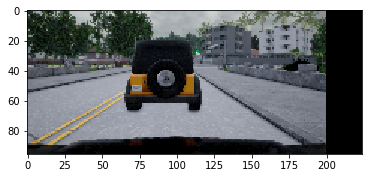

In [74]:
plt.imshow(x_out)

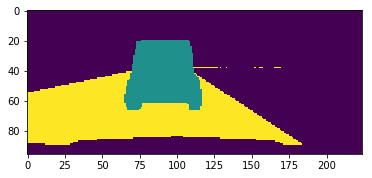

In [75]:
plt.imshow(y)

In [76]:
def new_acc(preds, targs):
    mx,idx = torch.max(preds, 1)
    return (idx == targs).float().mean()
def dice_mult(pred, targs):
#     pred = (pred>0).float()
    mx,idx = torch.max(pred, 1)
    pred = idx.float()
    targs = targs.float()
    return 2. * (pred*targs).sum() / (pred+targs).sum()
def dice(pred, targs):
    pred = (pred>0).float()
    return 2. * (pred*targs).sum() / (pred+targs).sum()

## U-net (ish)

In [77]:
f = resnet34
cut,lr_cut = model_meta[f]

In [78]:
def get_base():
    layers = cut_model(f(True), cut)
    return nn.Sequential(*layers)

In [79]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()

In [80]:
class UnetBlock(nn.Module):
    def __init__(self, up_in, x_in, n_out):
        super().__init__()
        up_out = x_out = n_out//2
        self.x_conv  = nn.Conv2d(x_in,  x_out,  1)
        self.tr_conv = nn.ConvTranspose2d(up_in, up_out, 2, stride=2)
        self.bn = nn.BatchNorm2d(n_out)
        
    def forward(self, up_p, x_p):
        up_p = self.tr_conv(up_p)
        x_p = self.x_conv(x_p)
        cat_p = torch.cat([up_p,x_p], dim=1)
        return self.bn(F.relu(cat_p, inplace=True))

In [81]:
class Unet34(nn.Module):
    def __init__(self, rn):
        super().__init__()
        self.rn = rn
        self.sfs = [SaveFeatures(rn[i]) for i in [2,4,5,6]]
        self.up1 = UnetBlock(512,256,256)
        self.up2 = UnetBlock(256,128,256)
        self.up3 = UnetBlock(256,64,256)
        self.up4 = UnetBlock(256,64,256)
        self.up5 = UnetBlock(256,3,16)
        self.up6 = nn.ConvTranspose2d(16, 3, 1)
        
    def forward(self,x):
        inp = x
        x = F.relu(self.rn(x), inplace=True)
        x = self.up1(x, self.sfs[3].features)
        x = self.up2(x, self.sfs[2].features)
        x = self.up3(x, self.sfs[1].features)
        x = self.up4(x, self.sfs[0].features)
        x = self.up5(x, inp)
        x = self.up6(x)
        return torch.squeeze(x)
    
    def close(self):
        for sf in self.sfs: sf.remove()

In [89]:

def make_one_hot(labels, C=2):
    one_hot = w(torch.FloatTensor(labels.size(0), C, labels.size(2), labels.size(3)).zero_())
    target = one_hot.scatter_(1, labels.data, 1)
    
    target = w(Variable(target))
        
    return target

class FocalLossMultiLabel(nn.Module):
    def __init__(self, gamma, weight):
        super().__init__()
        self.gamma = gamma
        self.nll = nn.NLLLoss(weight=weight, reduce=False)
        
    def forward(self, input, target):
        loss = self.nll(input, target)
        
        one_hot = make_one_hot(target.unsqueeze(dim=1), input.size()[1])
        inv_probs = 1 - input.exp()
        focal_weights = (inv_probs * one_hot).sum(dim=1) ** self.gamma
        loss = loss * focal_weights
        
        return loss.mean()

In [101]:

class FocalLoss(nn.Module):
    def __init__(self, gamma):
        super().__init__()
        self.gamma = gamma
        
    def forward(self, input, target):
        # Inspired by the implementation of binary_cross_entropy_with_logits
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})".format(target.size(), input.size()))

        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + ((-max_val).exp() + (-input - max_val).exp()).log()

        # This formula gives us the log sigmoid of 1-p if y is 0 and of p if y is 1
        invprobs = F.logsigmoid(-input * (target * 2 - 1))
        loss = (invprobs * self.gamma).exp() * loss
        
        return loss.mean()

In [90]:
class UnetModel():
    def __init__(self,model,name='unet'):
        self.model,self.name = model,name

    def get_layer_groups(self, precompute):
        if isinstance(self.model, FP16):
            model = self.model.module
        else:
            model = self.model
        lgs = list(split_by_idxs(children(model.rn), [lr_cut]))
#         print('LGS:', lgs)
#         print('Add:', children(model)[1:])
        return lgs + [children(model)[1:]]

In [138]:
def get_learner(md):
    m_base = get_base()
    m = to_gpu(Unet34(m_base))
    models = UnetModel(m)
    learn = ConvLearner(md, models)
    learn.opt_fn=optim.Adam
    class_weights = torch.FloatTensor([.1,.7,.2]).cuda()
    learn.crit=nn.CrossEntropyLoss(weight=class_weights)
#     learn.crit=FocalLoss(2)
#     learn.crit = nn.BCEWithLogitsLoss()
    learn.metrics=[new_acc]
    return learn

In [139]:
ext = '-150'
sz = 96
bs = 64
md = torch_loader('-150', PATH, bs, sz)

In [140]:
learn = get_learner(md)

In [141]:
# learn.half()

In [142]:
x,y = next(iter(md.trn_dl))

In [143]:
learn.freeze_to(1)

### Loading from train6 model

In [144]:
# learn.load('600urn-pad-instead')

 96%|█████████▌| 69/72 [00:06<00:00, 10.52it/s, loss=4.44] 

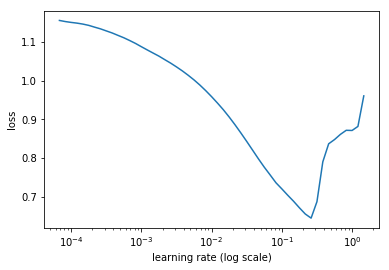

In [145]:
learn.lr_find()
learn.sched.plot()

In [146]:
# lr=1e-1
lr=1e-1
# lr=4e-3
wd=1e-5

lrs = np.array([lr/200,lr/20,lr])/2

In [147]:
learn.fit(lr,1,wds=wd,cycle_len=15,use_clr=(5,8))

epoch      trn_loss   val_loss   new_acc                   
    0      0.140576   0.153428   0.980207  
    1      0.078046   0.142502   0.968995                   
    2      0.062188   0.330394   0.883693                   
    3      0.055215   0.106156   0.985079                   
    4      0.057623   0.110053   0.964895                   
    5      0.051195   0.133057   0.98074                    
    6      0.048712   0.143573   0.983986                   
    7      0.044113   0.325234   0.927223                   
    8      0.045513   0.098517   0.985375                   
    9      0.042784   0.092186   0.973541                   
    10     0.040701   0.120088   0.979736                   
    11     0.040336   0.078019   0.983905                   
    12     0.036614   0.085272   0.981934                   
    13     0.035145   0.079071   0.983642                   
    14     0.0329     0.086171   0.986142                   


[array([0.08617]), 0.986142098903656]

In [148]:
learn.save(f'128urn-{S_PREFIX}-tmp')

In [149]:
learn.load(f'128urn-{S_PREFIX}-tmp')

In [150]:
learn.unfreeze()
learn.bn_freeze(True)

In [151]:
# lr=1e-1
lr=1e-2
# lr=4e-3
wd=1e-5

lrs = np.array([lr/200,lr/20,lr])/2

In [152]:
learn.fit(lrs/2, 1, wds=wd, cycle_len=10,use_clr=(20,10))

epoch      trn_loss   val_loss   new_acc                    
    0      0.026987   0.072866   0.985979  
    1      0.025538   0.071846   0.986593                   
    2      0.024516   0.072641   0.986725                   
    3      0.023411   0.076213   0.986987                   
    4      0.022944   0.07344    0.987429                   
    5      0.022322   0.072246   0.987354                   
    6      0.021706   0.074107   0.987354                   
    7      0.02121    0.072643   0.987207                   
    8      0.020782   0.074187   0.987317                   
    9      0.020353   0.074131   0.987547                   


[array([0.07413]), 0.9875465035438538]

In [153]:
learn.fit(lrs/2, 1, wds=wd, cycle_len=10,use_clr=(20,10))

epoch      trn_loss   val_loss   new_acc                    
    0      0.020776   0.072786   0.987762  
    1      0.020716   0.074094   0.986499                   
    2      0.020294   0.072953   0.987715                   
    3      0.019995   0.075024   0.987878                   
    4      0.019382   0.074163   0.987719                   
    5      0.018994   0.075274   0.987731                   
    6      0.018776   0.075557   0.987979                   
    7      0.01835    0.074072   0.987675                   
    8      0.017962   0.075586   0.987733                   
    9      0.017692   0.075825   0.987779                   


[array([0.07582]), 0.9877790212631226]

In [154]:
learn.save(f'128urn-{S_PREFIX}-0')

In [155]:
learn.load(f'128urn-{S_PREFIX}-0')

In [156]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

In [157]:
py = np.argmax(py,1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


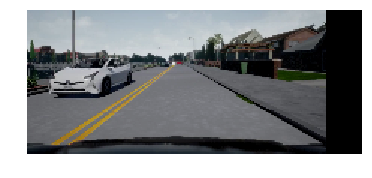

In [162]:
show_img(denorm(x[0]))

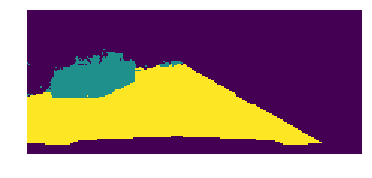

In [159]:
show_img(py[0]);

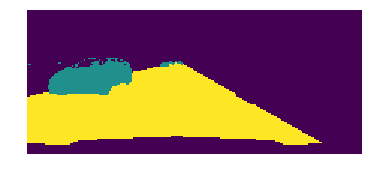

In [160]:
show_img(y[0]);

## 256x256

In [163]:
sz=192
bs=64

In [164]:
ext = '-300'
sz=192
bs=64
md = torch_loader(ext, PATH, bs, sz)

In [165]:
lr=1e-1
wd=1e-5

lrs = np.array([lr/200,lr/20,lr])/2

In [166]:
learn = get_learner(md)

In [167]:
learn.freeze_to(1)

 96%|█████████▌| 69/72 [00:21<00:00,  3.19it/s, loss=3.08] 

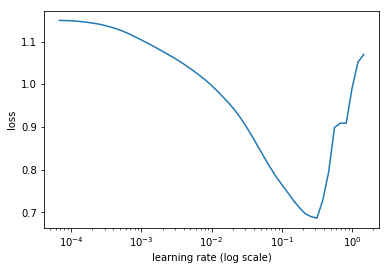

In [168]:
learn.lr_find()
learn.sched.plot()

In [169]:
learn.load(f'128urn-{S_PREFIX}-0')

In [170]:
learn.fit(lr,1,wds=wd, cycle_len=10,use_clr=(5,5))

epoch      trn_loss   val_loss   new_acc                    
    0      0.044802   0.441348   0.968689  
    1      0.03936    0.844141   0.852123                   
    2      0.037074   0.530318   0.812267                   
    3      0.035679   7.231835   0.538137                   
    4      0.036925   128.846725 0.672766                   
    5      0.033054   0.179422   0.982366                   
    6      0.031032   0.304226   0.913905                   
    7      0.027557   0.083345   0.97974                    
    8      0.025721   0.07984    0.979106                   
    9      0.025107   0.071454   0.988328                   


[array([0.07145]), 0.9883275628089905]

In [171]:
learn.save(f'256urn-{S_PREFIX}-tmp')

In [172]:
learn.unfreeze()
learn.bn_freeze(True)

In [173]:
learn.load(f'256urn-{S_PREFIX}-tmp')

In [174]:
learn.fit(lrs/6,1,wds=wd, cycle_len=8,use_clr=(20,8))

epoch      trn_loss   val_loss   new_acc                    
    0      0.021606   0.062142   0.98807   
    1      0.020882   0.065183   0.987696                   
    2      0.019165   0.063416   0.988622                   
    3      0.017878   0.064295   0.987611                   
    4      0.018373   0.067792   0.988269                   
    5      0.017375   0.066724   0.988736                   
    6      0.016652   0.066951   0.988797                   
    7      0.015977   0.066132   0.988533                   


[array([0.06613]), 0.9885333180427551]

In [175]:
learn.fit(lrs/6,1,wds=wd, cycle_len=8,use_clr=(20,8))

epoch      trn_loss   val_loss   new_acc                    
    0      0.016476   0.0656     0.988665  
    1      0.017056   0.065541   0.988821                   
    2      0.015953   0.068694   0.988147                   
    3      0.015206   0.068482   0.988917                   
    4      0.016163   0.066002   0.988622                   
    5      0.014962   0.066629   0.988892                   
    6      0.014398   0.067508   0.988794                   
    7      0.01402    0.068131   0.988833                   


[array([0.06813]), 0.988832950592041]

In [176]:
learn.save(f'256urn-{S_PREFIX}')

In [ ]:
learn.load(f'256urn-{S_PREFIX}')

In [177]:
x,y = next(iter(md.trn_dl))

In [178]:
x.shape

torch.Size([64, 3, 192, 416])

In [179]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

In [180]:
py = np.argmax(py,1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


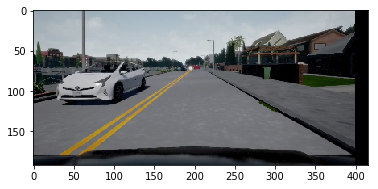

In [181]:
plt.imshow(denorm(x[-1]))

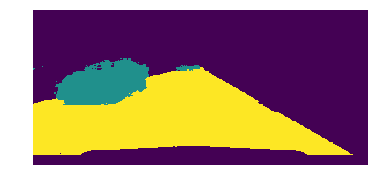

In [182]:
show_img(py[-1]);

In [186]:
py[-1].shape

(192, 416)

In [184]:
y[-1].shape

torch.Size([192, 416])

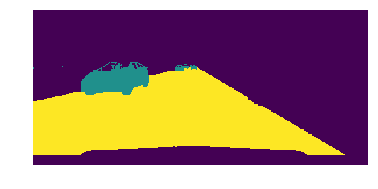

In [183]:
show_img(y[-1]);

In [ ]:
m.close()

## 512x512

In [187]:
TRAIN_DN = 'CameraRGB'
MASKS_DN = 'CameraSeg'
sz=288
bs=16

In [188]:
ext = ''
sz=288
bs=16
md = torch_loader(ext, PATH, bs, sz)

In [189]:
learn = get_learner(md)

In [190]:
learn.load(f'256urn-{S_PREFIX}')

In [191]:
learn.freeze_to(1)

In [192]:
lr=4e-2
wd=1e-4

lrs = np.array([lr/200,lr/20,lr])/2

In [193]:
learn.fit(lr,1, wds=wd, cycle_len=4,use_clr=(5,4))

epoch      trn_loss   val_loss   new_acc                      
    0      0.050931   2.501979   0.675682  
    1      0.070623   0.138712   0.970723                     
    2      0.037519   0.198221   0.916195                     
    3      0.031541   0.205953   0.928898                     


[array([0.20595]), 0.9288982113202413]

In [194]:
learn.save(f'600urn-{S_PREFIX}-tmp')

In [195]:
learn.load(f'600urn-{S_PREFIX}-tmp')

In [196]:
learn.unfreeze()
learn.bn_freeze(True)

In [197]:
lrs = np.array([lr/200,lr/30,lr])

In [198]:
learn.fit(lrs/10,1, wds=wd,cycle_len=4,use_clr=(20,8))

  1%|          | 2/288 [00:03<07:34,  1.59s/it, loss=0.0607]

RuntimeError: cuda runtime error (2) : out of memory at /opt/conda/conda-bld/pytorch_1518244421288/work/torch/lib/THC/generic/THCStorage.cu:58

In [ ]:
learn.fit(lrs/10,1, wds=wd,cycle_len=4,use_clr=(20,8))

In [ ]:
learn.sched.plot_loss()

In [88]:
learn.save(f'600urn-{S_PREFIX}')

In [ ]:
learn.load(f'600urn-{S_PREFIX}')

In [ ]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

In [ ]:
show_img(py[0]>0);

In [ ]:
show_img(y[0]);

## Save results

In [ ]:
import sys, skvideo.io, json, base64
import numpy as np
from PIL import Image
from io import BytesIO, StringIO

In [ ]:
m_base = get_base()
m = to_gpu(Unet34(m_base))

In [ ]:
# model_summary(m, [3,608,800])

In [ ]:
# learn.load('1024urn')
load_model(m, str(PATH/f'models/600urn-{S_PREFIX}.h5'))

In [ ]:
# file = sys.argv[-1]
file = 'test_video.mp4'

if file == 'demo.py':
    print("Error loading video")
    quit

# Define encoder function
def encode(array):
    pil_img = Image.fromarray(array)
    buff = BytesIO()
    pil_img.save(buff, format="PNG")
    return base64.b64encode(buff.getvalue()).decode("utf-8")

video = skvideo.io.vread(file)

In [ ]:
# resized_video = np.array([scipy.misc.imresize(f, size=(512,512)) for f in video])

In [ ]:
def normalize(x):
    if np.mean(x) > 1:
        x = x/255
    m,s = imagenet_stats
    x = (x-m)/s
    return x
def preprocess(video):
    f1_norm = normalize(video)
    f1_roll = np.rollaxis(f1_norm, 3, 1)
    f1_pad = np.pad(f1_roll, [(0,0),(0,0),(0,8),(0,0)], mode='constant')
    return f1_pad

In [ ]:
f1 = preprocess(video)

In [ ]:
results = []
for i in range(0,f1.shape[0],8):
    xv = VV(torch.from_numpy(f1[i:i+8]).contiguous().float())
    preds = m(xv)
    mx,idx = torch.max(preds, 1)
    idx_slice = idx[:,:-8,:]
    results.append(idx_slice)

In [ ]:
r_stacked = torch.cat(results,0)
r_np = r_stacked.data.cpu().numpy()

In [ ]:
import matplotlib.pyplot as plt
def plot_res(index):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 15))
    f.tight_layout()
    ax1.imshow(video[index])
    ax2.imshow(r_np[index])

In [ ]:
plot_res(10)

In [ ]:
answer_key = {}

# Frame numbering starts at 1
frame_idx = 1
for frame in r_np:
    # Look for red cars :)
    binary_car_result = (frame==1).astype('uint8')
#     print(np.mean(binary_car_result))
    
    # Look for road :)
    binary_road_result = (frame==2).astype('uint8')

    answer_key[frame_idx] = [encode(binary_car_result), encode(binary_road_result)]
    
    # Increment frame
    frame_idx+=1

# Print output in proper json format
tester_data = json.dumps(answer_key)
with open('tester_data_multi_take2', 'w') as f:
    f.write(tester_data)
print(json.dumps(answer_key))

### Decoding car

In [ ]:
PATH

In [ ]:
from scipy import misc
def decode(packet):
	img = base64.b64decode(packet)
	filename = PATH/'image.png'
	with open(filename, 'wb') as f:
			f.write(img)
	result = misc.imread(filename)
	return result

with open('results.json') as json_data:
	ans_data = json.loads(json_data.read())
	json_data.close()

In [ ]:
def plot_ans(index):
    ans = decode(ans_data[str(index)][0])
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 15))
    f.tight_layout()
    ax1.imshow(r_np[index])
    ax1.set_title('Mine', fontsize=35)
    ax2.imshow(ans)
    ax2.set_title('Answer', fontsize=35)
    ax3.imshow(video[index])
    ax2.set_title('Original', fontsize=35)

In [ ]:
plot_ans(10)

In [ ]:
ans = decode(ans_data['1'][0])

In [ ]:
import matplotlib.pyplot as plt
def plot_res(index):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 15))
    f.tight_layout()